# Regression example with missing data in the predictor

Adapted from https://gist.github.com/junpenglao/7c505c6c76f99c928a4e2c1161cff43a

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

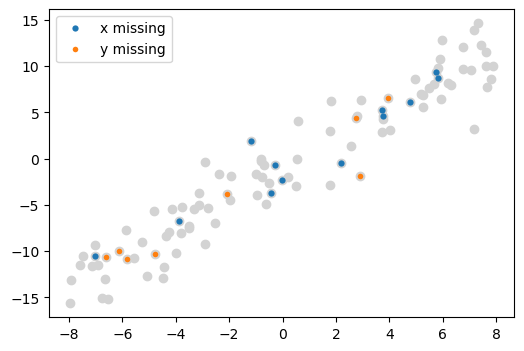

In [135]:
rng = np.random.default_rng(1234)

n_obs = 100
beta, sigma, c = 1.5, 2.3, -1.2

# x = rng.normal(scale=3., size=n_obs)
x = rng.uniform(low=-8,high=8, size=n_obs)
y = c + x*beta + rng.normal(
    scale=sigma, size=n_obs)
_, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, 'o', color='lightgrey');

mask_x = rng.binomial(n=1, p=.15, size=n_obs)==1
mask_y = rng.binomial(n=1, p=.1, size=n_obs)==1
ax.plot(x[mask_x], y[mask_x], '.', mew=0, ms=9, label='x missing')
ax.plot(x[mask_y], y[mask_y], '.', ms=8, mew=0, label='y missing')
ax.legend();

In [136]:
# missing values in x
x_missing = np.ma.masked_array(x, mask=mask_x)
y_missing = np.ma.masked_array(y, mask=mask_y)

In [183]:
N_SAMPLES = 100
with pm.Model() as model:
    coeff = pm.Normal('beta', 0, 5)
    intercept = pm.Normal('c', 0, 5)
    noise = pm.HalfNormal('sigma', 5)
    x_mu = pm.Normal('x_mu', mu=np.nanmean(x_missing), sigma=np.nanstd(x_missing), size=n_obs)
    # x_sigma = pm.HalfNormal('x_sigma', 1)
    x_modelled = pm.Normal("x", mu=x_mu, sigma=0.1, observed=x_missing)
    observed = pm.Normal('y', mu=intercept + coeff*x_modelled, sigma=noise, observed=y_missing)
    # Sample from prior
    idata = pm.sample_prior_predictive(samples=N_SAMPLES) 

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in x contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [beta, c, sigma, x_mu, x_observed, x_unobserved, y_observed, y_unobserved]


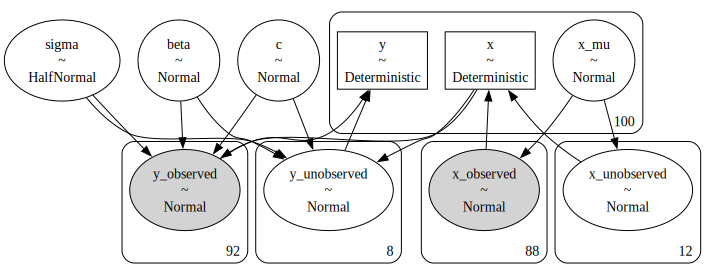

In [184]:
gv = pm.model_to_graphviz(model)
gv

In [185]:
model.free_RVs

[beta ~ Normal(0, 5),
 c ~ Normal(0, 5),
 sigma ~ HalfNormal(0, 5),
 x_mu ~ Normal(-0.0519, 4.99),
 x_unobserved,
 y_unobserved]

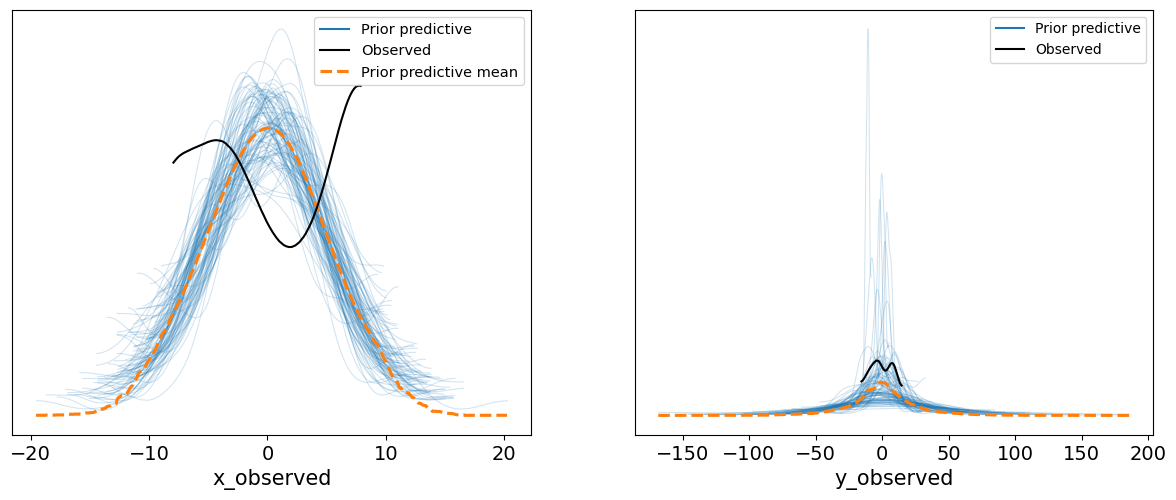

In [186]:
ax = az.plot_ppc(idata, group='prior', observed=True)

In [187]:
# posterior sampling
with model:
    idata.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, c, sigma, x_mu, x_unobserved, y_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.


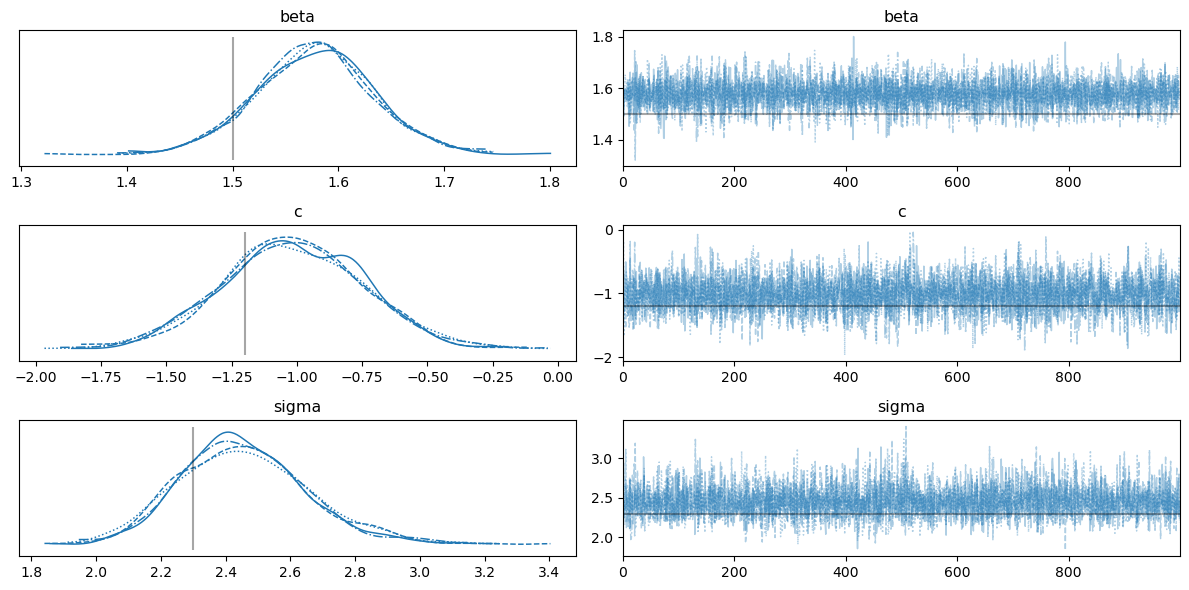

In [188]:
lines = (
    ('beta', {}, beta),
    ('c', {}, c),
    ('sigma', {}, sigma)
)

_ = az.plot_trace(idata,var_names=["~x","~x_unobserved","~y","~y_unobserved","~x_mu"],lines=lines)
plt.tight_layout()

In [189]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [x_observed, y_observed, y_unobserved]


Output()

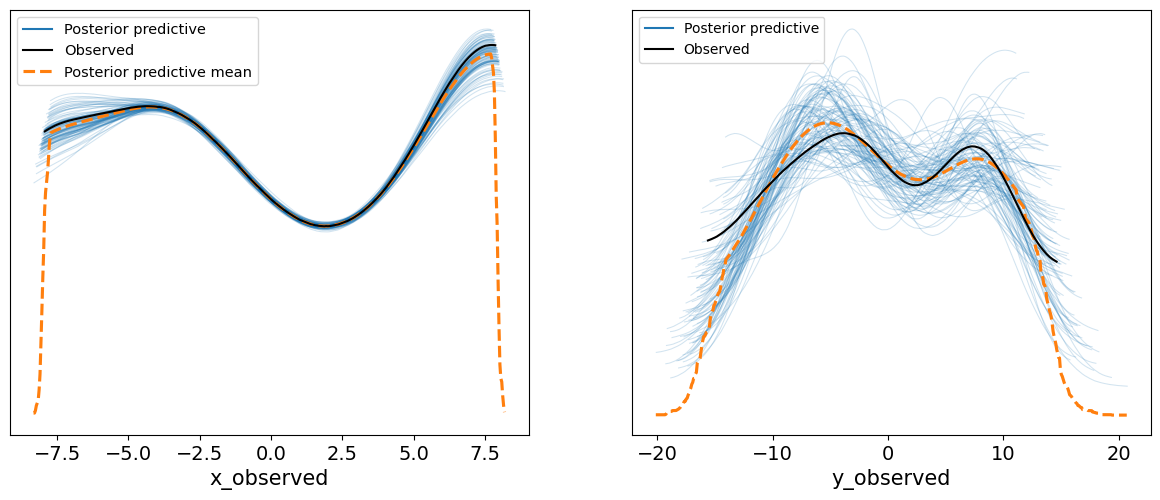

In [190]:
ax = az.plot_ppc(idata, num_pp_samples=100)

In [191]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

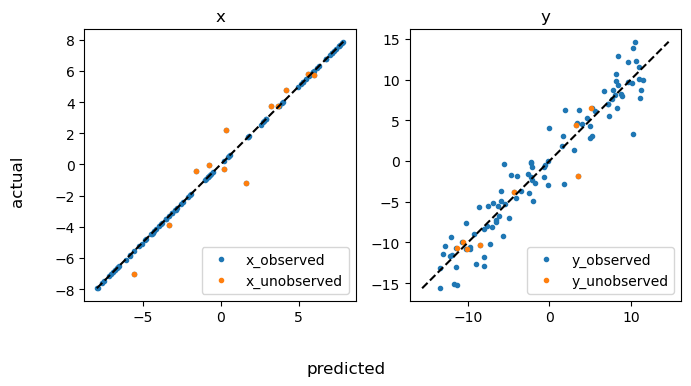

In [192]:
stacked = idata.stack(samples=("chain","draw"))

fig, ax= plt.subplots(1,2,figsize=(7,4))

ax[0].plot(stacked.posterior_predictive["x"].mean("samples"),x,'.',label='x_observed')
ax[0].plot(stacked.posterior["x_unobserved"].mean("samples"),x[mask_x],'.',label='x_unobserved')
ax[0].plot([x.min(),x.max()],[x.min(),x.max()],'k--')
ax[0].set_aspect("equal")
ax[0].set_title("x")
ax[0].legend(loc=4)

ax[1].plot(stacked.posterior_predictive["y"].mean("samples"),y,'.',label='y_observed')
ax[1].plot(stacked.posterior["y_unobserved"].mean("samples"),y[mask_y],'.',label='y_unobserved')
ax[1].plot([y.min(),y.max()],[y.min(),y.max()],'k--')
ax[1].set_aspect("equal")
ax[1].set_title("y")
ax[1].legend(loc=4)
fig.supxlabel("predicted")
fig.supylabel("actual")
fig.tight_layout()

In [193]:
with model:
    pm.compute_log_likelihood(idata)

Output()

<Axes: xlabel='x_observed'>

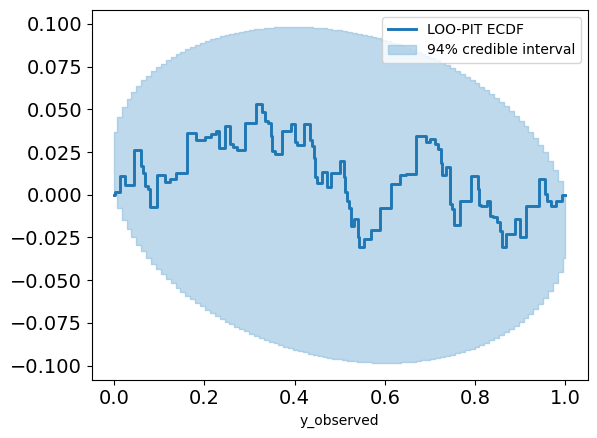

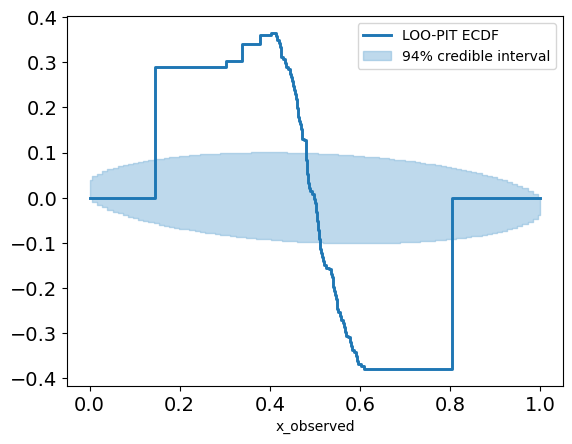

In [194]:
az.plot_loo_pit(idata, y="y_observed", ecdf=True)
az.plot_loo_pit(idata, y="x_observed", ecdf=True)